# Perform parameter estimation in a notebook #



### Make sure the software is set up ###


In [1]:
import sys
!{sys.executable} -m pip install pycbc ligo-common emcee==2.2.1 --no-cache-dir

## Estimating the distance ##

A `model` in pycbc inference represents the problem you are trying to solve. It contains the definition of the likelihood function you want to explore and details the parameters you are using. Let's take a look at some of the existing models that pycbc inference provides targeted at gravitational-wave data analysis. We'll start with the `SingleTemplate` model. This model is useful when we know the intrinsic parameters of a source (i.e. component masses, spins), but we don't know the extrinsic parameters (i.e. sky location, distance, binary orientation). This will allow us to estimate the distance to GW170817 and the inclination of the orbital plan from our viewing angle. 

This model requires a specifc set of data products.
  * Dictionary of frequency-domain data (keyed by observatory short name such as 'H1', 'L1', 'V1').
  * Dictionary of power spectral density estimates
  * Low frequency cutoff to use for internal filtering in the model
  
We will make use of PyCBC gw signal processing tools to prepare this data.

In [2]:
from pycbc.catalog import Merger
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.frame import read_frame
from pycbc.filter import highpass, resample_to_delta_t
from astropy.utils.data import download_file

m = Merger("GW170817")

# List of observatories we'll analyze
ifos = ['H1', 
        'V1', 
        'L1',
       ]

In [35]:
# we'll keep track of the filename locations as we'll need them later
data_filenames = {}

# The single template waveform model needs these data products
psds = {}
data = {}

for ifo in ifos:
    print("Processing {} data".format(ifo))
    
    # Download the gravitational wave data for GW170817
    url = "https://dcc.ligo.org/public/0146/P1700349/001/{}-{}1_LOSC_CLN_4_V1-1187007040-2048.gwf"
    fname = download_file(url.format(ifo[0], ifo[0]), cache=True) 
    # Load into the memory
    data_filenames[ifo] = fname
    
    # Read the gravitational wave data and do some minimal
    # conditioning of the data.
    ts = read_frame(fname, "{}:LOSC-STRAIN".format(ifo),
                    start_time=int(m.time - 260),
                    end_time=int(m.time + 40)) 
    ts = highpass(ts, 15.0)                     
    # Remove low frequency content
    ts = resample_to_delta_t(ts, 1.0/2048)      
    # Resample data to 2048 Hz # Downsample to lower sampling rate
    ts = ts.time_slice(m.time-112, m.time + 16) 
    # Limit to times around the signal
    data[ifo] = ts.to_frequencyseries()         
    # Convert to a frequency series by taking the data's FFT

    # Estimate the power spectral density of the data
    psd = interpolate(ts.psd(4), ts.delta_f)
    psd = inverse_spectrum_truncation(psd, int(4 * psd.sample_rate), 
                                      trunc_method='hann',
                                      low_frequency_cutoff=20.0)
    psds[ifo] = psd



Processing H1 data
Processing V1 data
Processing L1 data


# Signal

Has two polarizations. Described by 15 parameters + 1 parameter per NS.
1. Intrinsic Parameters: Masses, spins etc.
2. Extrinsic Parameters: distance, sky location (RA, Dec) etc.

<p style="text-align: center;"><img src="mass1.png" alt="drawing" width="800"/></p>

Aligned Spins = Longer duration

<iframe width="1000" height="315" src="https://vijayvarma392.github.io/binaryBHexp/movies/hangup.mp4" title="YouTube video" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>


Misaligned Spin = Amplitude Variation

<iframe width="1000" height="315" src="https://vijayvarma392.github.io/binaryBHexp/movies/precessing.mp4" title="YouTube video" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

# Morphology of Signal with Mass

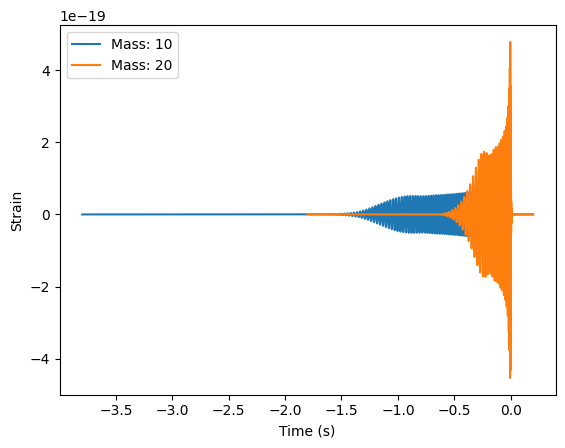

In [4]:
import matplotlib.pyplot as pp
from pycbc.waveform import get_td_waveform



hp, hc = get_td_waveform(approximant='IMRPhenomD',
                             mass1=10,
                             mass2=10,
                             spin1z=0.9,
                             delta_t=1.0/4096,
                             f_lower=40)

pp.plot(hp.sample_times, hp, label='Mass: 10')

hp, hc = get_td_waveform(approximant='IMRPhenomD',
                             mass1=20,
                             mass2=20,
                             spin1z=0.9,
                             delta_t=1.0/4096,
                             f_lower=40)

pp.plot(hp.sample_times, hp, label='Mass: 20')

pp.ylabel('Strain')
pp.xlabel('Time (s)')
pp.legend()
pp.show()

# Morphology of Signal with Spin

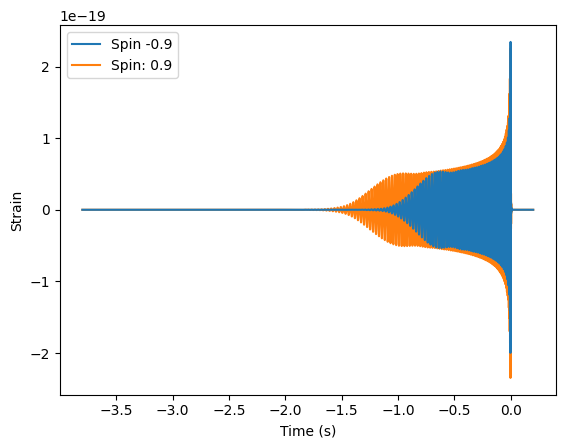

In [28]:
import matplotlib.pyplot as pp
from pycbc.waveform import get_td_waveform



hp, hc = get_td_waveform(approximant='IMRPhenomD',
                             mass1=10,
                             mass2=10,
                             spin1z=-0.9,
                             spin2z=-0.9,
                             delta_t=1.0/4096,
                             f_lower=40)

pp.plot(hp.sample_times, hp, label='Spin -0.9',zorder=1)

hp, hc = get_td_waveform(approximant='IMRPhenomD',
                             mass1=10,
                             mass2=10,
                             spin1z=0.9,
                             spin2z=0.9,
                             delta_t=1.0/4096,
                             f_lower=40)

pp.plot(hp.sample_times, hp, label='Spin: 0.9',zorder=0)

pp.ylabel('Strain')
pp.xlabel('Time (s)')
pp.legend()
pp.show()

# Morphology of Signal with Distance

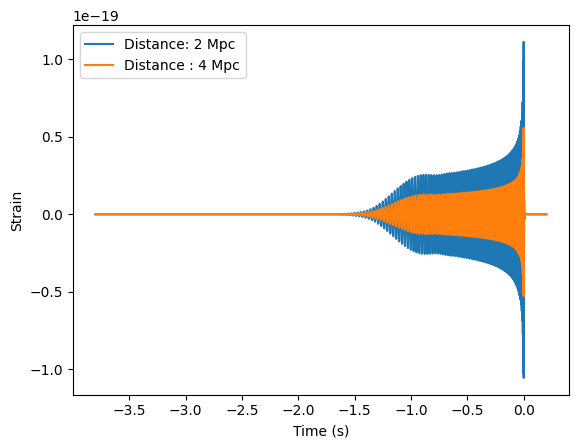

In [5]:
import matplotlib.pyplot as pp
from pycbc.waveform import get_td_waveform



hp, hc = get_td_waveform(approximant='IMRPhenomD',
                             mass1=10,
                             mass2=10,
                             spin1z=0.9,
                             distance = 2.0,
                             delta_t=1.0/4096,
                             f_lower=40)

pp.plot(hp.sample_times, hp, label='Distance: 2 Mpc')

hp, hc = get_td_waveform(approximant='IMRPhenomD',
                             mass1=10,
                             mass2=10,
                             spin1z=0.9,
                             distance = 4.0,
                             delta_t=1.0/4096,
                             f_lower=40)

pp.plot(hp.sample_times, hp, label='Distance : 4 Mpc')

pp.ylabel('Strain')
pp.xlabel('Time (s)')
pp.legend()
pp.show()

# Morphology of Signal with Inclination

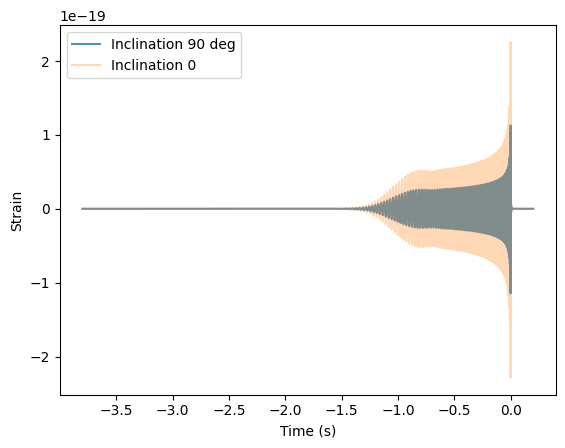

In [49]:
import matplotlib.pyplot as pp
from pycbc.waveform import get_td_waveform
import numpy as np


hp, hc = get_td_waveform(approximant='IMRPhenomD',
                             mass1=10,
                             mass2=10,
                            inclination=np.pi/2,
                             delta_t=1.0/4096,
                             f_lower=40)

pp.plot(hp.sample_times, hp, label='Inclination 90 deg',alpha=0.8)

hp, hc = get_td_waveform(approximant='IMRPhenomD',
                             mass1=10,
                             mass2=10,
                            inclination=0,
                             delta_t=1.0/4096,
                             f_lower=40)

pp.plot(hp.sample_times, hp, label='Inclination 0',alpha=0.3)

pp.ylabel('Strain')
pp.xlabel('Time (s)')
pp.legend()
pp.show()

A number of parameters must also be provided as 'static' parameters. These include 
   * mass1 (Units in solar masses)
   * mass2 (Units in solar masses)
   * f_lower (used for where to start our gravitational waveform model generation from)
   * approximant (This sets which waveform model we are using)

If a model supports other intrinsic parameters (such as components spins), they may 
also optionally be provided.

There are also a fixed set of 'variable' parameters. These are the only ones which we
can obtain estimates of with this model. These are
   * ra        (Units in radians)
   * dec       (Units in radians)
   * distance  (Units in Megaparsecs)
   * inclination (Units in radians)
   * polarization (Units in radians)
   * tc           (Units in seconds): This parameter is roughly the time of merger.
   
It's important to note that anything which could be a variable paramater, can be transformed
into a static parameter by supplying a specific value for it. We take advantage of this below
to limit our analyis to only sample over 'distance', 'inclination', and 'tc'. We set the sky location
to the location of NGC 4993, the galaxy where an electromagnetic counterpart to GW170817 was observed.

In [6]:
from pycbc.inference import models, sampler
from pycbc.distributions import Uniform, JointDistribution, SinAngle
import numpy

static = {'mass1':2*1.3757,
          'mass2':2*1.3757,
          'f_lower':25.0,
          'approximant':"TaylorF2",
          'polarization':0,
          'ra': 3.44615914,
          'dec': -0.40808407
         } # double the mass of GW170817

variable = ('distance',
            'inclination',
            'tc')

prior = JointDistribution(variable,
                SinAngle(inclination=None), 
                Uniform(
                    distance=(10, 100),
                    tc=(m.time-.2, m.time+0.2),
                )
        )

We are not ready to create our SingleTemplate model instance. Note how the variable and static parameters
are passed to the model. This is a common way this information can be passed for built-in pycbc inference models.

Notice that we are no longer using the Emcee sampler. While Emcee is sufficient for many problems, EmceePT, a parallel tempered version of Emcee is more effective at most gravitational-wave data analysis problems. There is one additional parameter we need to give to EmcceePT which is the number of temperatures. The output of this sampler will thus be 3-dimensional (temps x walkers x iterations). The 'coldest' temperature (0) will contain our actual results. 

In [7]:
import copy
model = models.SingleTemplate(variable, copy.deepcopy(data),
                              low_frequency_cutoff={'H1':25, 'L1':25, 'V1':25},
                              psds = psds,
                              static_params = static,
                              prior = prior,
                              sample_rate = 8192,
                              )
smpl = sampler.EmceePTSampler(model, 3, 200, nprocesses=8)
_ = smpl.set_p0() # If we don't set p0, it will use the models prior to draw initial points!

In [8]:
# Note it may take ~1-3 minutes for this to run
smpl.run_mcmc(200)

In addition to the sampled parameters, we can also get the likelihood values our model produces. 

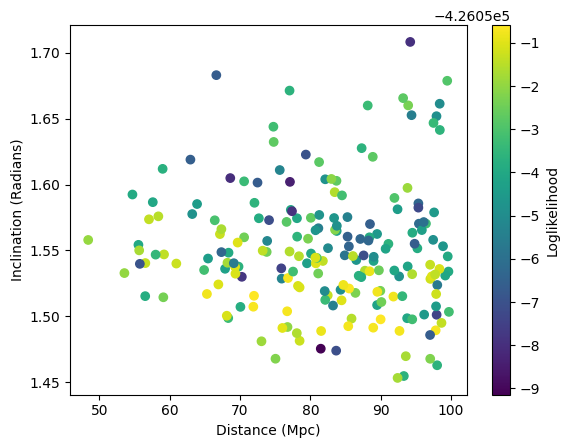

In [9]:
import pylab

lik = smpl.model_stats['loglikelihood']
s = smpl.samples

# Note how we have to access the arrays differently that before since there is an additional dimension. 
# The zeroth element of that dimension represents the 'coldest' and is the one we want for our results.
# The other temperatures represent a modified form of the likelihood that allows walkers to traverse
# the space more freely.
pylab.scatter(s['distance'][0,:,-1],
              s['inclination'][0,:,-1],
              c=lik[0,:,-1])
pylab.xlabel('Distance (Mpc)')
pylab.ylabel('Inclination (Radians)')

c = pylab.colorbar()
c.set_label('Loglikelihood')
pylab.show()

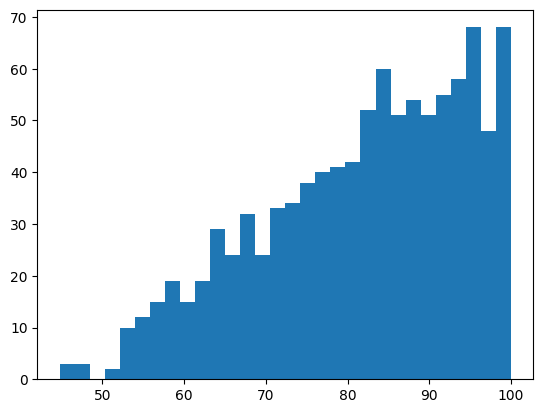

In [10]:
_ = pylab.hist(s['distance'][0,:,-100::20].flatten(), bins=30)

In [11]:
import pickle

# Read dictionary pkl file
with open('par1.pkl', 'rb') as fp:
    s1 = pickle.load(fp)
    
# Read dictionary pkl file
with open('lik1.pkl', 'rb') as fp:
    lik1 = pickle.load(fp)


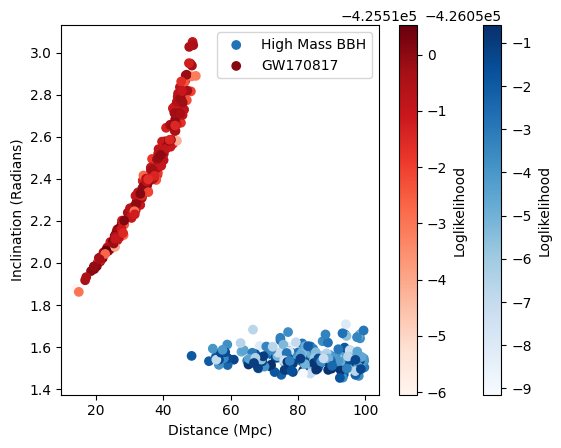

In [12]:
import pylab

lik = smpl.model_stats['loglikelihood']
s = smpl.samples

# Note how we have to access the arrays differently that before since there is an additional dimension. 
# The zeroth element of that dimension represents the 'coldest' and is the one we want for our results.
# The other temperatures represent a modified form of the likelihood that allows walkers to traverse
# the space more freely.
pylab.scatter(s['distance'][0,:,-1],
              s['inclination'][0,:,-1],
              c=lik[0,:,-1],label="High Mass BBH", cmap='Blues')
c = pylab.colorbar()
c.set_label('Loglikelihood')
pylab.scatter(s1['distance'][0,:,-1],
              s1['inclination'][0,:,-1],
              c=lik1[0,:,-1],label="GW170817", cmap='Reds')
c = pylab.colorbar()
c.set_label('Loglikelihood')

pylab.xlabel('Distance (Mpc)')
pylab.ylabel('Inclination (Radians)')
pylab.legend()

pylab.show()


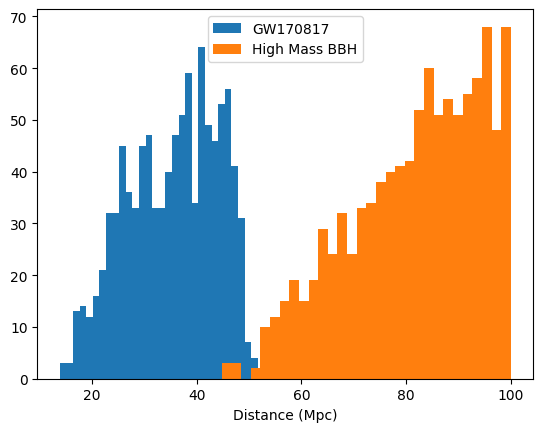

In [13]:
_1 = pylab.hist(s1['distance'][0,:,-100::20].flatten(), bins=30,label='GW170817')
_ = pylab.hist(s['distance'][0,:,-100::20].flatten(), bins=30, label='High Mass BBH')
pylab.xlabel('Distance (Mpc)')
pylab.legend()

pylab.show()

## Estimate all the parameters ##

In the previous example we quickly estimated the extrinsic parameters of GW170817 by fixing the intrinsic. This was fast, since it did not require regenerating a waveform for each likelihood evaluation. Now let's try estimating the masses of GW170817. This is generally slower, since it requires generating a waveform on each likelihood call. However, in the example below, we'll use the [relative binning model](https://pycbc.org/pycbc/latest/html/pycbc.inference.models.html#pycbc.inference.models.relbin.Relative). This uses a technique presented in [Zackay et al.](https://arxiv.org/abs/1806.08792). Basically, a reference waveform is used that's close to the peak likelihood. A linear approximation is used to interpolate the likelihood around this waveform, reducing the number of frequency points that we need to evaluate, and speeding up the analysis.

To do this, we'll use the same `data.ini` and `sampler.ini` files as above. We'll change the `model` to the `relative` one and provide the necessary arguments to generate the fiducial waveform. We'll make the chirp mass (`mchirp`) and symmetric mass ratio (`eta`) the variable parameters; for speed, we'll fix the extrinsic parameters.

### Setup the config files

In [50]:
model_config = """
[model]
name = relative
low-frequency-cutoff = 25.0
high-frequency-cutoff = 1024.0
epsilon = 0.03
mass1_ref = 1.3757
mass2_ref = 1.3757
tc_ref = ${data|trigger-time}
"""

In [51]:
!echo '{model_config}' > model.ini
!cat model.ini


[model]
name = relative
low-frequency-cutoff = 25.0
high-frequency-cutoff = 1024.0
epsilon = 0.03
mass1_ref = 1.3757
mass2_ref = 1.3757
tc_ref = ${data|trigger-time}



In [52]:
prior_config = """
[variable_params]
mass1 =
mass2 =
distance =
ra =
dec =
inclination =
delta_tc = 

[static_params]
f_lower = 25.0
approximant = TaylorF2
polarization = 0

[prior-mass1]
name = uniform
min-mass1 = 1
max-mass1 = 2

[prior-mass2]
name = uniform
min-mass2 = 1
max-mass2 = 2

[prior-distance]
name = uniform
min-distance = 10
max-distance = 100

[prior-inclination]
name = sin_angle

[prior-ra+dec]
; sky position prior
name = uniform_sky

[prior-delta_tc]
name = uniform
min-delta_tc = -0.1
max-delta_tc = 0.1

[waveform_transforms-tc]
name = custom
inputs = delta_tc
tc = ${data|trigger-time} + delta_tc

"""

In [53]:
!echo '{prior_config}' > prior.ini
!cat prior.ini


[variable_params]
mass1 =
mass2 =
distance =
ra =
dec =
inclination =
delta_tc = 

[static_params]
f_lower = 25.0
approximant = TaylorF2
polarization = 0

[prior-mass1]
name = uniform
min-mass1 = 1
max-mass1 = 2

[prior-mass2]
name = uniform
min-mass2 = 1
max-mass2 = 2

[prior-distance]
name = uniform
min-distance = 10
max-distance = 100

[prior-inclination]
name = sin_angle

[prior-ra+dec]
; sky position prior
name = uniform_sky

[prior-delta_tc]
name = uniform
min-delta_tc = -0.1
max-delta_tc = 0.1

[waveform_transforms-tc]
name = custom
inputs = delta_tc
tc = ${data|trigger-time} + delta_tc




### Run

*Note: this may take several minutes to run.*

In [54]:
!pycbc_inference --verbose \
    --config-files model.ini data.ini prior.ini sampler.ini \
    --output-file inference-all.hdf \
    --seed 3214897 \
    --nprocesses 8 \
    --force    

2023-07-19T21:55:35.296+05:30 Using seed 3214897
2023-07-19T21:55:35.297+05:30 Running with CPU support: 1 threads
2023-07-19T21:55:35.490+05:30 Reading configuration file
2023-07-19T21:55:35.529+05:30 Setting up model
2023-07-19T21:55:35.533+05:30 Setting up priors for each parameter
2023-07-19T21:55:35.536+05:30 No sampling_params section read from config file
2023-07-19T21:55:35.536+05:30 Loading waveform transforms
2023-07-19T21:55:35.546+05:30 Determining analysis times to use
2023-07-19T21:55:35.547+05:30 Padding H1 analysis start and end times by 2 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2023-07-19T21:55:35.547+05:30 Padding L1 analysis start and end times by 2 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2023-07-19T21:55:35.547+05:30 Padding V1 analysis start and end times by 2 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2023-07-19T21:55:35.549+05:30 Reading Frames
2023-07-19T21:55:46.596+

### Plot the posterior

In [56]:
!pycbc_inference_plot_posterior --verbose \
    --input-file inference-all.hdf \
    --output-file posterior.png \
    --plot-scatter --plot-marginal --z-arg snr\
    --expected-parameters 'mass1:1.3757' 'mass2:1.3757'


2023-07-19T22:10:55.457+05:30 Reading input file inference-all.hdf
2023-07-19T22:10:55.459+05:30 Loading samples
2023-07-19T22:10:55.591+05:30 Loaded 1400 samples
2023-07-19T22:10:55.592+05:30 Getting samples for colorbar
2023-07-19T22:10:55.614+05:30 Plotting
2023-07-19T22:11:04.939+05:30 Done


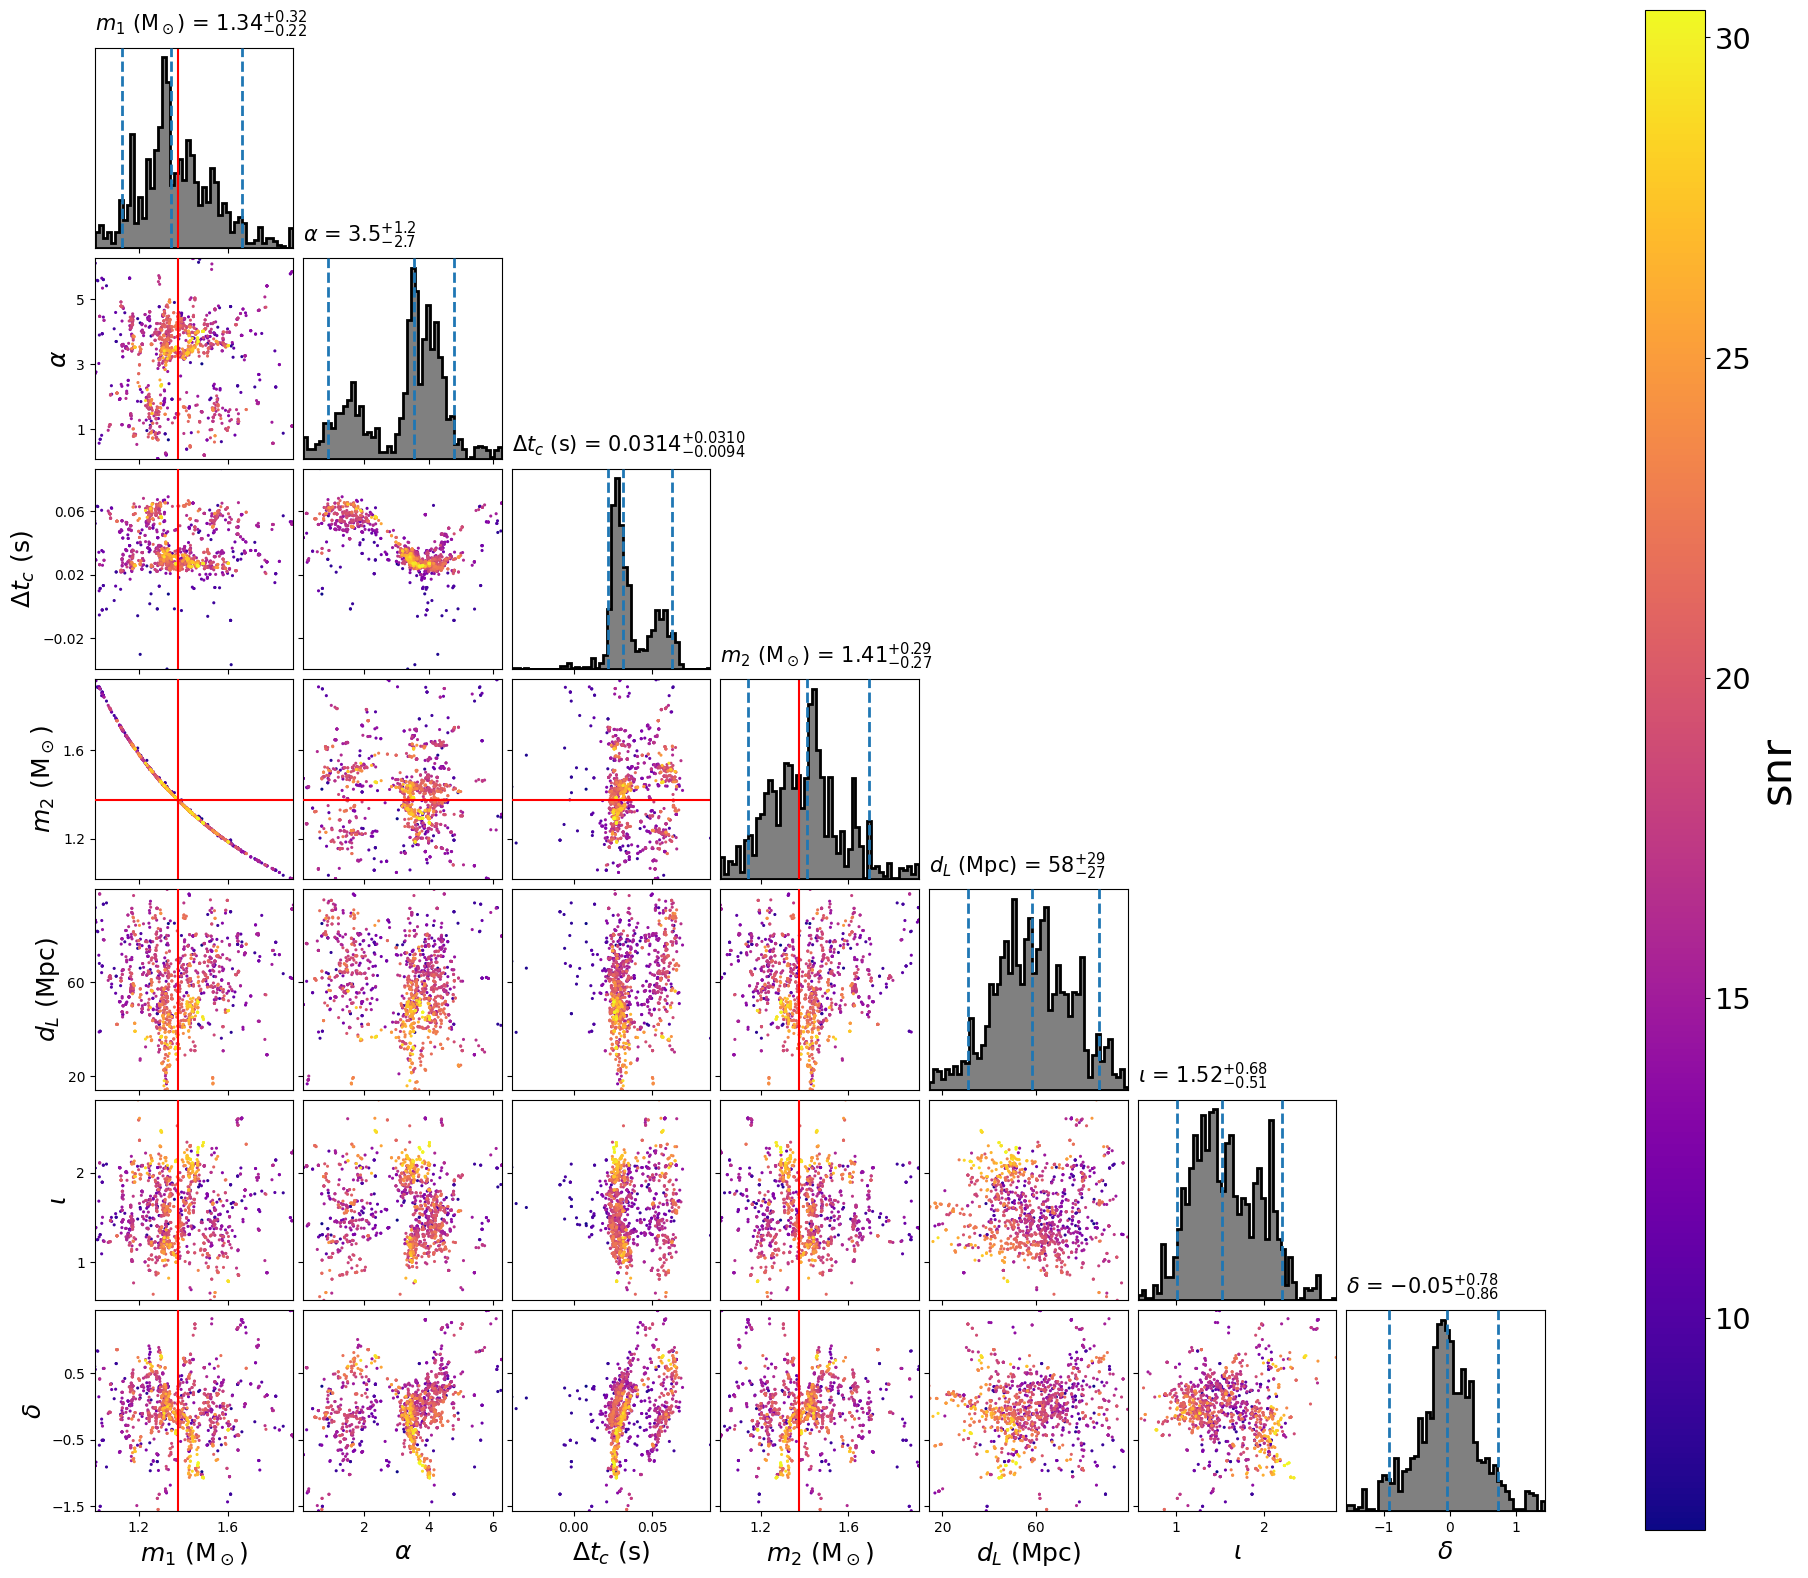

In [58]:
from IPython.display import Image
Image('posterior.png', height=480)

### Get the extrinsic parameters

For speed, we'll fix the extrinsic parameters. We'll use our previous results using the `SingleTemplate` model to get the maximum likelihood values of the distance, inclination, and coalescence time. To do that, we'll use `pycbc_inference_table_summary` to print out a table of the values.

In [59]:
!pycbc_inference_table_summary \
    --input-file inference-all.hdf \
    --output-file posterior_summary.html \
    --verbose

2023-07-19T22:13:59.065+05:30 Reading input file inference-all.hdf
2023-07-19T22:13:59.068+05:30 Loading samples
2023-07-19T22:13:59.132+05:30 Loaded 1400 samples


In [60]:
from IPython.display import HTML
HTML('posterior_summary.html')

Parameter,90% Credible Interval,Maximum Posterior,Maximum Likelihood
$m_2~(\mathrm{M}_\odot)$,$1.41^{+0.29}_{-0.27}$,$1.29$,$1.29$
$\iota$,$1.52^{+0.68}_{-0.51}$,$2.28$,$2.28$
$\alpha$,$3.5^{+1.2}_{-2.7}$,$3.7$,$3.7$
$m_1~(\mathrm{M}_\odot)$,$1.34^{+0.32}_{-0.22}$,$1.47$,$1.47$
$\delta$,$-0.05^{+0.78}_{-0.86}$,$-0.85$,$-0.85$
$\Delta t_c~(\rm{s})$,$0.0314^{+0.0310}_{-0.0094}$,$0.0254$,$0.0254$
$d_L$ (Mpc),$58^{+29}_{-27}$,$52$,$52$
